# Plot kinetic energy from ORCA12

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
from dask.distributed import Client, LocalCluster, wait
from matplotlib.animation import FuncAnimation

In [2]:
plt.style.use('dark_background')

In [3]:
cluster = LocalCluster(n_workers=8, threads_per_worker=2, memory_limit=32e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36881 instead
  expected, actual


In [4]:
client

Client Scheduler: tcp://127.0.0.1:38895 Dashboard: http://127.0.0.1:36881/status,Cluster Workers: 8 Cores: 16 Memory: 238.42 GiB


## Read mesh

In [5]:
ds_m = xr.open_dataset('/gxfs_work1/geomar/smomw352/mask_orca12.nc')
tmask = ds_m['tmask'][0,:,:,:]
ds_h = xr.open_dataset('/gxfs_work1/geomar/smomw352/mesh_hgr_orca12.nc')
e1t = ds_h['e1t'][0,:,:]
e2t = ds_h['e2t'][0,:,:]
areacello = e1t * e2t

In [6]:
areacello

<xarray.DataArray (y: 3059, x: 4322)>
array([[4.33837030e+06, 4.33837030e+06, 4.33837030e+06, ...,
        4.33837030e+06,            nan,            nan],
       [4.35068383e+06, 4.35068383e+06, 4.35068383e+06, ...,
        4.35068383e+06,            nan,            nan],
       [4.36303200e+06, 4.36303200e+06, 4.36303200e+06, ...,
        4.36303200e+06,            nan,            nan],
       ...,
       [2.60772135e+03, 3.96432120e+01, 3.11167740e+03, ...,
        3.12633844e+03,            nan,            nan],
       [2.18179728e+03, 4.95174837e+01, 3.81565733e+03, ...,
        3.81505769e+03,            nan,            nan],
       [2.74519404e+03, 3.32983937e+01, 2.24098055e+03, ...,
        2.76110678e+03,            nan,            nan]])
Dimensions without coordinates: y, x

In [7]:
def global_sfcmean(data):
    
    weights = (areacello * tmask[0,:,:]).fillna(0)
    weights.name = "weights"
    data_weighted = data.weighted(weights)
    weighted_mean = data_weighted.mean(("x", "y"))
    
    return weighted_mean

## Read data

In [ ]:
# BJK016 - spinup of Jan 1950
# BJK017 - Feb 1950 - Dec 1952 (until crash)
# BJK019 - cont of BJK019 with changed land mask

expnames = ['FOCI_BJK017','FOCI_BJK019']
times = [slice('1950-02-01','1952-12-31'),slice('1953-01-01','1956-12-31')]

In [10]:
# Put each experiment in a list 
u_5d_all = []
v_5d_all = []

for i, (exp,time) in enumerate( zip(expnames, times) ):
    
    time_str = '*'
    chunks = {'x':200, 'y':200, 'deptht': 1, 'depthu':1, 'depthv':1}
    
    ddir = '/gxfs_work1/geomar/smomw352/esm-experiments/%s/outdata/nemo/' % (exp,)
    ufiles = '%s/%s_5d_%s_grid_U.nc' % (ddir,exp,time_str)
    print(ufiles)
    u_5d = xr.open_mfdataset(ufiles,combine='by_coords', chunks=chunks).rename({'time_counter':'time'}).sel(time=time)
    
    vfiles = '%s/%s_5d_%s_grid_V.nc' % (ddir,exp,time_str)
    print(vfiles)
    v_5d = xr.open_mfdataset(vfiles,combine='by_coords', chunks=chunks).rename({'time_counter':'time'}).sel(time=time)
    
    u_5d_all.append(u_5d)
    v_5d_all.append(v_5d)
    

/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK017/outdata/nemo//FOCI_BJK017_5d_*_grid_U.nc
/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK017/outdata/nemo//FOCI_BJK017_5d_*_grid_V.nc
/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK019/outdata/nemo//FOCI_BJK019_5d_*_grid_U.nc
/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK019/outdata/nemo//FOCI_BJK019_5d_*_grid_V.nc


In [12]:
u_5d.chunk({'time':-1})

,Array,Chunk
Bytes,13.99 GiB,43.33 MiB
Shape,"(284, 3059, 4322)","(284, 200, 200)"
Count,70326 Tasks,414 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,13.99 GiB,43.33 MiB
Shape,"(284, 3059, 4322)","(284, 200, 200)"
Count,70326 Tasks,414 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


## Calculate kinetic energy, KE

Only for the surface!

$K_\mathrm{E} = \frac{1}{2} (u_s^2 + v_s^2)$

In [20]:
chunks = {'x':200, 'y':200, 'time':-1}

ke_all = []

for ds_u, ds_v in zip(u_5d_all, v_5d_all):
    print('compute u')
    _u = ds_u['uoce'].rename({'depthu':'deptht'}).isel(deptht=0).chunk(chunks)
    print('compute v')
    _v = ds_v['voce'].rename({'depthv':'deptht'}).isel(deptht=0).chunk(chunks)
    print('compute ke')
    da_ke = ((_u**2).chunk(chunks) + (_v**2).chunk(chunks))
    print('store')
    ke_all.append(da_ke.chunk(chunks) * 1/2.)

KilledWorker: ("('array-b7a35e652e2126f0025f1e45c7e0d643', 0, 0, 0)", <WorkerState 'tcp://127.0.0.1:41831', name: 4, memory: 0, processing: 1>)

In [19]:
_u

,Array,Chunk
Bytes,13.99 GiB,43.33 MiB
Shape,"(284, 3059, 4322)","(284, 200, 200)"
Count,3871697 Tasks,352 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,13.99 GiB,43.33 MiB
Shape,"(284, 3059, 4322)","(284, 200, 200)"
Count,70264 Tasks,352 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


## Split to mean and eddy KE 

In [17]:
run = 36 # 3x3 deg smoothing (1/12 * 36 = 3)

um = ds_u['uoce'].rename({'depthu':'deptht'}).isel(deptht=0).rolling(x=run,center=True).mean().rolling(y=run,center=True).mean().chunk({'time':1})
vm = ds_v['voce'].rename({'depthv':'deptht'}).isel(deptht=0).rolling(x=run,center=True).mean().rolling(y=run,center=True).mean().chunk({'time':1})

In [20]:
um

<xarray.DataArray 'uoce' (time: 284, y: 3059, x: 4322)>
dask.array<truediv, shape=(284, 3059, 4322), dtype=float64, chunksize=(1, 3058, 4321), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (time, y, x) float32 dask.array<chunksize=(1, 2364, 2161), meta=np.ndarray>
    nav_lon        (time, y, x) float32 dask.array<chunksize=(1, 2364, 2161), meta=np.ndarray>
    deptht         float32 0.5058
    time_centered  (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time           (time) datetime64[ns] 1953-01-03T12:00:00 ... 1956-12-28T1...
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_x_velocity
    long_name:           ocean current along i-axis
    units:               m/s
    online_operation:    average
    interval_operation:  300 s
    interval_write:      5 d
    cell_methods:        time: mean (interval: 300 s)

In [18]:
ue = (ds_u['uoce'].rename({'depthu':'deptht'}).isel(deptht=0) - um).chunk({'time':1})
ve = (ds_v['voce'].rename({'depthv':'deptht'}).isel(deptht=0) - vm).chunk({'time':1})

In [21]:
ue

<xarray.DataArray 'uoce' (time: 284, y: 3059, x: 4322)>
dask.array<sub, shape=(284, 3059, 4322), dtype=float64, chunksize=(1, 3058, 4321), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (time, y, x) float32 dask.array<chunksize=(1, 2364, 2161), meta=np.ndarray>
    nav_lon        (time, y, x) float32 dask.array<chunksize=(1, 2364, 2161), meta=np.ndarray>
    deptht         float32 0.5058
    time_centered  (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time           (time) datetime64[ns] 1953-01-03T12:00:00 ... 1956-12-28T1...
Dimensions without coordinates: y, x

In [22]:
eke = (ue**2 + ve**2).chunk({'time':1}) * 1/2.

KilledWorker: ("('array-c610dabc31b88bcde02f16fb459720c0', 0, 0, 0)", <WorkerState 'tcp://127.0.0.1:33107', name: 7, memory: 0, processing: 1>)

## Global mean KE

In [ ]:
ke_mean_all = []
for da_ke in ke_all:
    ke_mean = global_sfcmean(da_ke).compute()
    ke_mean_all.append(ke_mean)

In [ ]:
ke = xr.concat(ke_mean_all, dim='time')

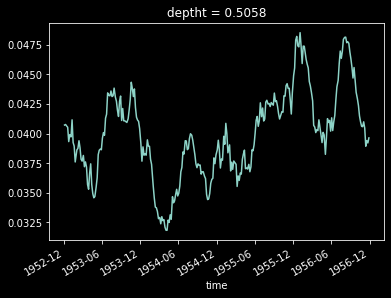

In [36]:
fig1, ax1 = plt.subplots(1,1)

ke_mean.plot(ax=ax1)

In [61]:
nsteps = len(da_speed['time'])

for ji in range(0, nsteps):
    
    _speed = da_speed.isel(time=ji)
    
    plot_speed(_speed, save=True)
    

## Plot SST and ice

In [11]:
# Number of time steps
nsteps = len(ds_t['time'])
nsteps

284

In [26]:
def plot_sst_ice(sst, ice, region='global', save=False):
    
    fig1 = plt.figure(figsize=(8,6))
    
    ax1 = fig1.add_axes([0.1,0.1,0.8,0.8])
    cax1 = fig1.add_axes([0.92, 0.1, 0.01, 0.39])
    cax2 = fig1.add_axes([0.92, 0.51, 0.01, 0.39])
    
    # this will make NaNs black
    ax1.set_facecolor('Gainsboro')
    
    # apply mask
    _sst = sst.where(sst != 0)
    _ice = ice.where(ice > 0.15) * 100
    
    if region == 'weddell':
        vmin, vmax = -2, 30
    else:
        vmin, vmax = -2, 30
    
    cbar_kwargs = {'orientation':'vertical', 'pad':0.02, 'label':'[C]'}
    _sst.plot.pcolormesh(ax=ax1, cmap=cmocean.cm.thermal, 
                         vmin=vmin, vmax=vmax, 
                         cbar_kwargs=cbar_kwargs,
                         cbar_ax=cax1,
                         rasterized=True)
    
    cbar_kwargs = {'orientation':'vertical', 'pad':0.02, 'label':'[%]'}
    _ice.plot.pcolormesh(ax=ax1, cmap=cmocean.cm.ice, 
                         vmin=0, vmax=100, 
                         cbar_kwargs=cbar_kwargs,
                         cbar_ax=cax2,
                         rasterized=True)
    
    if region == 'weddell':
        ax1.set_xlim([2517, 3897])
        ax1.set_ylim([61,   1111])
    
    ax1.set_xticks([])
    ax1.set_xlabel('')
    ax1.set_xticklabels([])
    ax1.set_yticks([])
    ax1.set_yticklabels([])
    ax1.set_ylabel('')
    ax1.set_title('SST and sea-ice concentration')
    
    if save:
        fig1.savefig('frames/sst_ice_%s_%04d.png' % (region,ji), format='png', dpi=300)
        plt.close(fig1)
    

In [18]:
for ji in range(0, nsteps):
    
    # load in the data
    sst = ds_t['sst'].isel(time=ji).load()
    ice = ds_i['ileadfra'].isel(time=ji).load()
    
    fig1 = plt.figure(figsize=(8,6))
    
    ax1 = fig1.add_axes([0.1,0.1,0.8,0.8])
    cax1 = fig1.add_axes([0.92, 0.1, 0.01, 0.39])
    cax2 = fig1.add_axes([0.92, 0.51, 0.01, 0.39])
    
    # this will make NaNs black
    ax1.set_facecolor('Gainsboro')
    
    # apply mask
    _sst = sst.where(sst != 0)
    _ice = ice.where(ice > 0.15) * 100
    
    cbar_kwargs = {'orientation':'vertical', 'pad':0.02, 'label':'[C]'}
    _sst.plot.pcolormesh(ax=ax1, cmap=cmocean.cm.thermal, 
                         vmin=-2, vmax=30, 
                         cbar_kwargs=cbar_kwargs,
                         cbar_ax=cax1,
                         rasterized=True)
    
    cbar_kwargs = {'orientation':'vertical', 'pad':0.02, 'label':'[%]'}
    _ice.plot.pcolormesh(ax=ax1, cmap=cmocean.cm.ice, 
                         vmin=0, vmax=100, 
                         cbar_kwargs=cbar_kwargs,
                         cbar_ax=cax2,
                         rasterized=True)
    
    ax1.set_xticks([])
    ax1.set_xlabel('')
    ax1.set_xticklabels([])
    ax1.set_yticks([])
    ax1.set_yticklabels([])
    ax1.set_ylabel('')
    ax1.set_title('SST and sea-ice concentration')
    
    fig1.savefig('frames/sst_ice_%04d.png' % (ji,), format='png', dpi=300)
    plt.close(fig1)

In [27]:
for ji in range(0, nsteps):
    
    # load in the data
    sst = ds_t['sst'].isel(time=ji).load()
    ice = ds_i['ileadfra'].isel(time=ji).load()
    
    plot_sst_ice(sst, ice, region='weddell', save=True)